### Boosting Decisions

In this notebook, we build some understanding about the boosting process using Adaptive Boosting and Gradient Boosted Trees methods.

It accompanies Chapter 6 of the book (notebook 2 of 4). The final application will be the photometric redshift problem introduced in the notebook "Photoz_RandomForest.ipynb"; however, specific solution for that problem are explored in the notebook "FlavorsOfBoosting.ipynb".

Copyright: Viviana Acquaviva (2023); see also other data credits below.

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

We are using [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/), for inspiration.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor

Reference for comparison of weak learners as base estimators:

https://link.springer.com/chapter/10.1007/978-3-642-20042-7_32

### We can read in the photometric redshifts data set with the selection criteria applied in the previous notebook.

In [ ]:
sel_features = pd.read_csv('sel_features.csv', sep = '\t')

In [ ]:
sel_target = pd.read_csv('sel_target.csv')

In [ ]:
sel_features.shape

(6307, 6)

In [ ]:
sel_target.values.ravel() #changes shape to 1d row-like array

array([1.0034, 0.9023, 0.4242, ..., 0.3703, 0.371 , 0.7333])

### We can try our usual benchmarking with AdaBoost, using default values.

In [ ]:
model = AdaBoostRegressor()

In [ ]:
ypred = cross_val_predict(model, sel_features,sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 3)

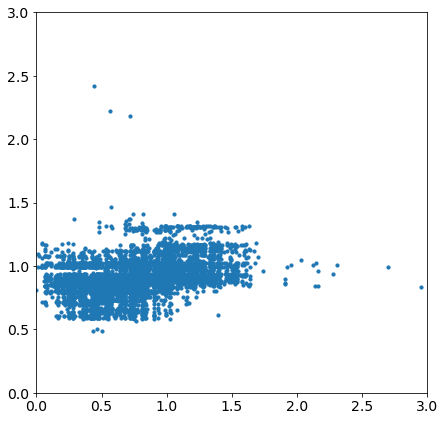

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.ylim(0,3)
plt.xlim(0,3)

### This is where I started wondering whether the boosting process was working at all :) 

In [ ]:
model.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

Note (from sklearn docs): If None, then the base estimator is DecisionTreeRegressor(max_depth=3).

### My hypothesis was that in AdaBoost, stacking weak base estimators (short trees, for example) would not be beneficial. I tested this first on a toy model, inspired by https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#sphx-glr-auto-examples-ensemble-plot-adaboost-regression-py

 

#### This is what happens if max_depth = 3.

r2 score:  0.721
r2 score:  0.483
r2 score:  0.678
r2 score:  0.685
r2 score:  0.679


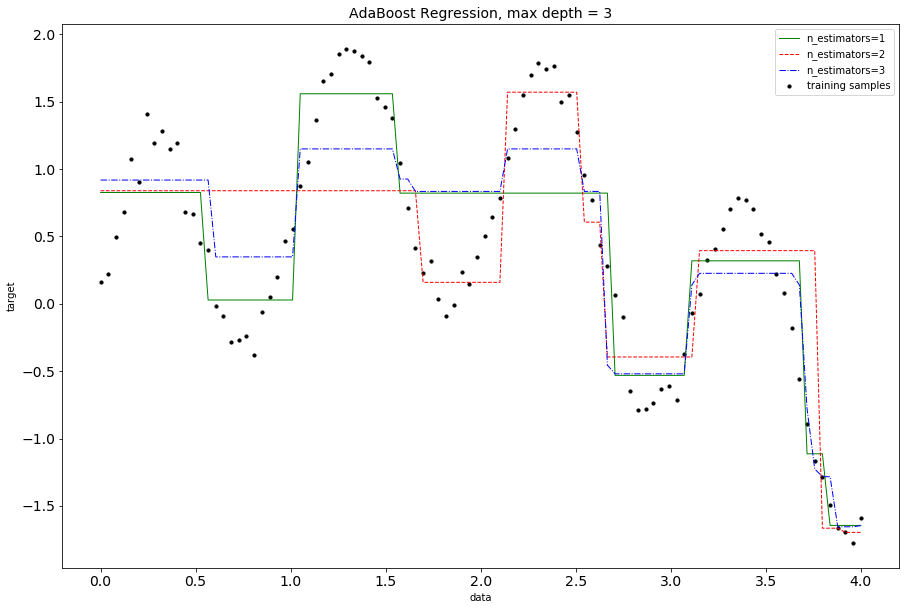

In [ ]:
# Create the dataset
plt.figure(figsize=(15,10))

rng = np.random.RandomState(1)
X = np.linspace(0, 4, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

weakl = DecisionTreeRegressor(max_depth=3)

# Fit regression model, saving each "stage"

regr_1 = weakl
""
regr_2 = AdaBoostRegressor(weakl,
                          n_estimators=2, random_state=rng)

regr_3 = AdaBoostRegressor(weakl,
                          n_estimators=3, random_state=rng)

regr_4 = AdaBoostRegressor(weakl,
                          n_estimators=4, random_state=rng)

regr_10 = AdaBoostRegressor(weakl,
                          n_estimators=10, random_state=rng)

regr_100 = AdaBoostRegressor(weakl,
                          n_estimators=100, random_state=rng)


regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_10.fit(X, y)
regr_100.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)
y_4 = regr_4.predict(X)
y_10 = regr_10.predict(X)

for yp in [y_1,y_2,y_3,y_4,y_10]:
    print('r2 score: ', np.round(metrics.r2_score(yp,y),3))

# Plot the results

plt.scatter(X, y, c="k", s=10,label="training samples")
plt.plot(X, y_1, "-g", label="n_estimators=1", linewidth=1)
plt.plot(X, y_2, "--r", label="n_estimators=2", linewidth=1)
plt.plot(X, y_3, "-.b", label="n_estimators=3", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("AdaBoost Regression, max depth = 3", fontsize = 14)
plt.legend(fontsize=10);
#plt.tight_layout()
#plt.savefig("AdaBoost_3.png")

#### This is what happens if max_depth = 6

0.9865752135159646
0.9278575583200374
0.9839942271148489
0.9870344388780988
0.993347003156994


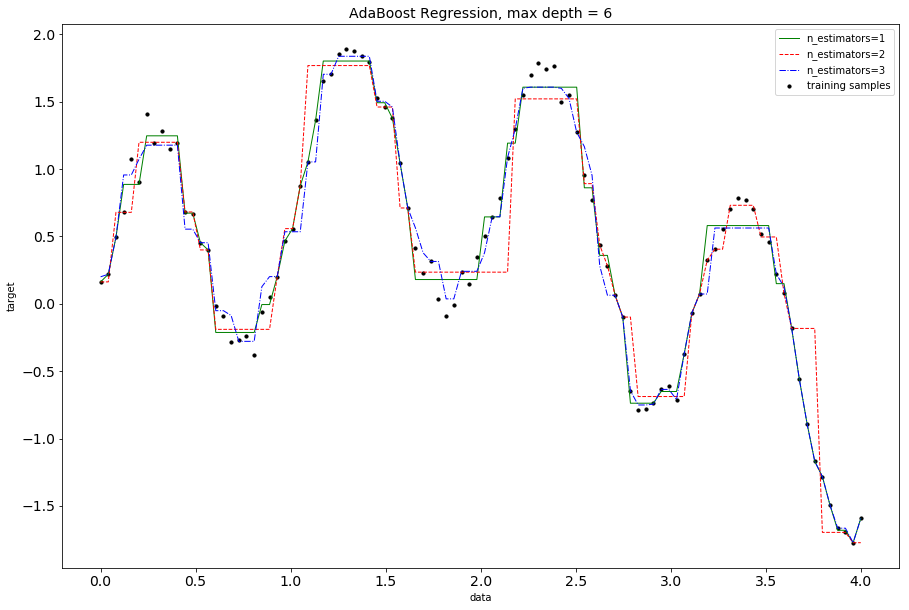

In [ ]:
# Create the dataset
plt.figure(figsize=(15,10))

rng = np.random.RandomState(1)
X = np.linspace(0, 4, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

weakl = DecisionTreeRegressor(max_depth=6)

# Fit regression model, saving each "stage"
regr_1 = weakl
""
regr_2 = AdaBoostRegressor(weakl,
                          n_estimators=2, random_state=rng)

regr_3 = AdaBoostRegressor(weakl,
                          n_estimators=3, random_state=rng)

regr_4 = AdaBoostRegressor(weakl,
                          n_estimators=4, random_state=rng)

regr_10 = AdaBoostRegressor(weakl,
                          n_estimators=10, random_state=rng)

regr_100 = AdaBoostRegressor(weakl,
                          n_estimators=100, random_state=rng)


regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_10.fit(X, y)
regr_100.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)
y_4 = regr_4.predict(X)
y_10 = regr_10.predict(X)

for yp in [y_1,y_2,y_3,y_4,y_10]:
    print(metrics.r2_score(yp,y))

# Plot the results

plt.scatter(X, y, c="k", s=10,label="training samples")
plt.plot(X, y_1, "-g", label="n_estimators=1", linewidth=1)
plt.plot(X, y_2, "--r", label="n_estimators=2", linewidth=1)
plt.plot(X, y_3, "-.b", label="n_estimators=3", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("AdaBoost Regression, max depth = 6", fontsize = 14)
plt.legend(fontsize=10);
#plt.tight_layout()
#plt.savefig("AdaBoost_6.png")
plt.show()

### This seemed to confirm my working hypothesis! We can now go back to the photo-z determination problem.

We create a train/test split because we need to use the ".fit" method in order to access the "staged_predict" property to examine how the prediction changes at each stage.

In [ ]:
X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

We begin with a very weak learner: 

In [ ]:
model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=30)

In [ ]:
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=30)

We can plot the R2 score and the Spearman correlation coefficient between true and predicted values as a function of the number of stages/iterations.

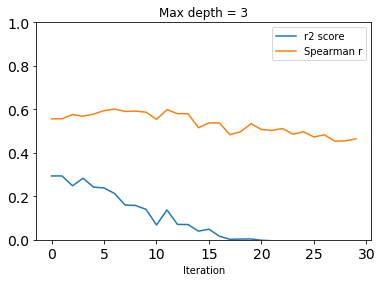

In [ ]:
n_estimators = 30

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score')

plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r')

plt.xlabel('Iteration')

plt.ylim(0,1.0)

plt.title('Max depth = 3')
plt.legend();

### The scores don't seem to improve as we stack more estimators.

### We can now try again with a stronger base learner (max_depth = 6).

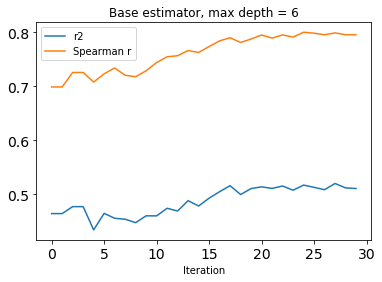

In [ ]:
n_estimators = 30

model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  n_estimators=n_estimators)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 6')

plt.legend();

### And do the same with an even stronger base learner (max_depth = 10).

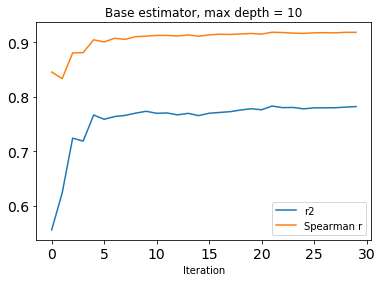

In [ ]:
n_estimators = 30

model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  n_estimators=30)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 10')

plt.legend();

### Let's combine all of them in one figure.

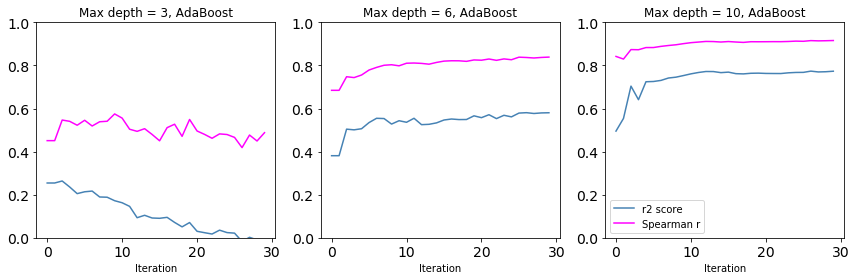

In [ ]:
plt.figure(figsize=(12,4))

n_estimators = 30

for i, md in enumerate([3,6,10]):
    
    model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=md),
                  n_estimators=n_estimators)

    model.fit(X_train,y_train)
    
    plt.subplot(1,3,i+1)

    plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score', c = 'steelblue')

    plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r', c = 'fuchsia')

    plt.xlabel('Iteration')

    plt.ylim(0,1.0)

    plt.title('Max depth = '+str(md)+', AdaBoost')
    
    if i == 2:
        plt.legend();
    
    plt.tight_layout()

#plt.savefig('AdaB_performance.png')

### We sort-of have an answer from the third panel of the figure above, but we could also ask whether we should keep boosting (i.e. if adding more stages is beneficial.).

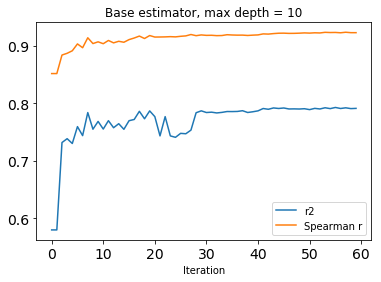

In [ ]:
#Shall we keep boosting? (max_depth = 10)

n_estimators = 60

model= AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  n_estimators=n_estimators)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 10')

plt.legend();


### Conclusions: 

1.   Stacking learners that are too weak doesn't help;
2.   There is a plateau in the boosting stages so that adding more estimators is not beneficial.





### Would this be true also for Gradient Boosted Trees algorithms?

There is only one way to find out!

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

The parameters depend on the particular implementation.

In the sklearn formulation, the parameters of each tree are essentially the same we have for Random Forests; additionally we have the "learning_rate" parameter, which dictates how much each tree contribute to the final estimator, and the "subsample" parameters, which allows one to use a < 1.0 fraction of samples.


We can check how this works with a weak learner on our toy data set.

R2 score:  0.721
R2 score:  -28.773
R2 score:  -11.218
R2 score:  -6.118
R2 score:  0.005
R2 score:  0.998


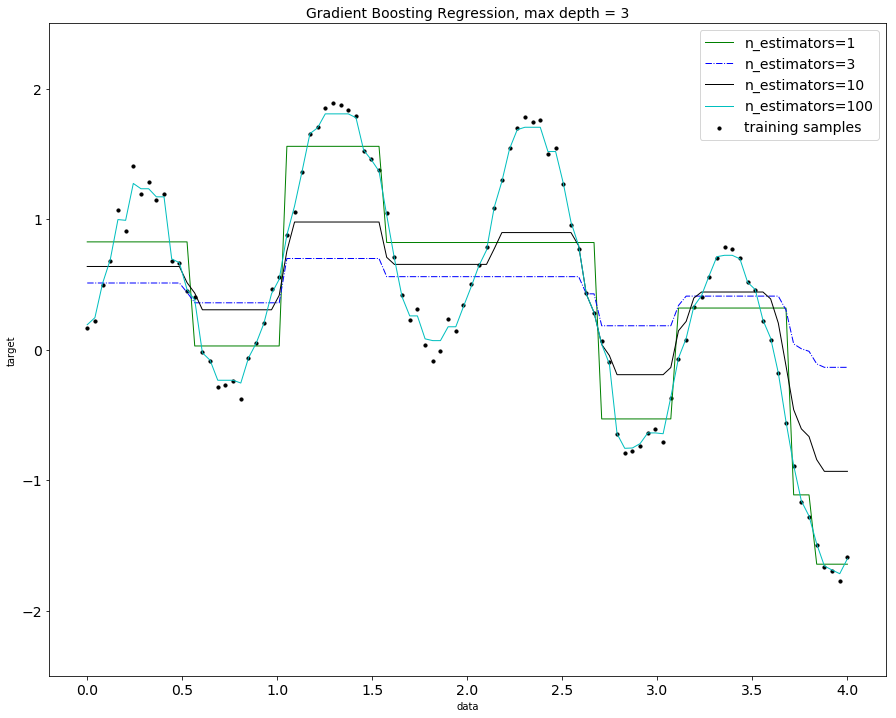

In [ ]:
# Create the dataset

plt.figure(figsize=(15,12))

rng = np.random.RandomState(1)
X = np.linspace(0, 4, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

weakl = DecisionTreeRegressor(max_depth=3)

# Fit regression model
regr_1 = weakl
""
regr_2 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=2, random_state=rng)

regr_3 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=3, random_state=rng)

regr_4 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=4, random_state=rng)

regr_10 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=10, random_state=rng)

regr_100 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=100, random_state=rng)


regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_10.fit(X, y)
regr_100.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)
y_4 = regr_4.predict(X)
y_10 = regr_10.predict(X)
y_100 = regr_100.predict(X)

for yp in [y_1,y_2,y_3,y_4,y_10, y_100]:
    print('R2 score: ', np.round(metrics.r2_score(yp,y),3))

# Plot the results

plt.scatter(X, y, c="k", s=10,label="training samples")
plt.plot(X, y_1, "-g", label="n_estimators=1", linewidth=1)
plt.plot(X, y_3, "-.b", label="n_estimators=3", linewidth=1)
plt.plot(X, y_10, "-k", label="n_estimators=10", linewidth=1)
plt.plot(X, y_100, "-c", label="n_estimators=100", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.ylim(-2.5,2.5)
plt.title("Gradient Boosting Regression, max depth = 3", fontsize = 14)
plt.legend(fontsize=14, loc = 'upper right');
#plt.tight_layout()
#plt.savefig("GradBoost_3.png")

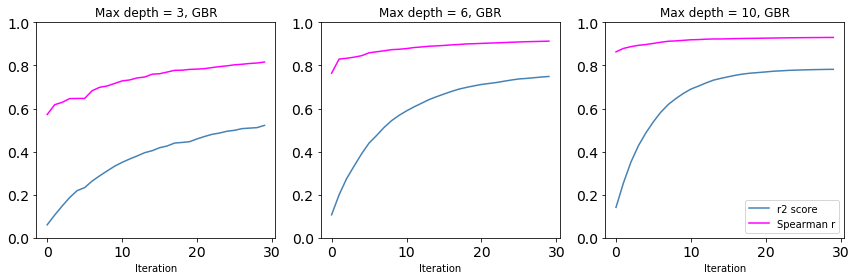

In [ ]:
plt.figure(figsize=(12,4))

n_estimators = 30

for i, md in enumerate([3,6,10]):
    
    model = GradientBoostingRegressor(max_depth=md,
                  n_estimators=n_estimators)

    model.fit(X_train,y_train)
    
    plt.subplot(1,3,i+1)

    plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score', c = 'steelblue')

    plt.plot(range(n_estimators), [stats.spearmanr(y_test,list(model.staged_predict(X_test))[i])[0] for i in range(n_estimators)], label = 'Spearman r', c = 'fuchsia')

    plt.xlabel('Iteration')

    plt.ylim(0,1.0)

    plt.title('Max depth = '+str(md)+', GBR')
    
    if i == 2:
        plt.legend();
    
    plt.tight_layout()

#plt.savefig('GBR_performance.pdf')

### Because of the different boosting process, GBT models tend to work well even with weak base learners.

We compare the performance of AdaBoost and various GBT models on the photometric redshifts problem in the next notebook (FlavorsOfBoosting).